Auto Insurance Crash Risk Modeling
Full Jupyter Notebook Pipeline
SC, PA, TN + FARS National Analysis

In [94]:
# PART 0: Setup and Introduction

print("#" * 80)
print("# Opioid-Involved Crash Prediction and Impact Analysis")
print("#" * 80)
print(f"Analysis Run Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

print("""
### Introduction
This script performs an analysis of vehicle crash data from South Carolina (SC),
Pennsylvania (PA), and Tennessee (TN), with a focus on identifying factors
associated with opioid involvement. It compares several predictive models,
evaluates their performance using various metrics, explores feature importance,
and simulates the potential financial impact of interventions. Data from the
Fatality Analysis Reporting System (FARS) is loaded separately for potential
comparison but is not the primary focus of this modeling pipeline.
""")

################################################################################
# Opioid-Involved Crash Prediction and Impact Analysis
################################################################################
Analysis Run Date: 2025-05-03 10:41:01


### Introduction
This script performs an analysis of vehicle crash data from South Carolina (SC),
Pennsylvania (PA), and Tennessee (TN), with a focus on identifying factors
associated with opioid involvement. It compares several predictive models,
evaluates their performance using various metrics, explores feature importance,
and simulates the potential financial impact of interventions. Data from the
Fatality Analysis Reporting System (FARS) is loaded separately for potential
comparison but is not the primary focus of this modeling pipeline.



In [95]:
print("\n" + "=" * 60)
print("# PART 1: Loading Libraries and Setting Configuration")
print("=" * 60)

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, r2_score, mean_squared_error, mean_absolute_error # Ensure MAE is here
)
from sklearn.preprocessing import StandardScaler # Note: StandardScaler is imported but not used. Remove if not needed.
from sklearn.linear_model import LinearRegression
from imblearn.over_sampling import SMOTE
import shap

warnings.filterwarnings('ignore')
sns.set_style('whitegrid') # Set a default plot style
plt.rcParams['figure.dpi'] = 100 # Set default plot resolution


# PART 1: Loading Libraries and Setting Configuration


This section loads all necessary libraries, sets configuration paths,
enables a "test mode" to sample smaller subsets, and defines conservative crash cost mappings.

In [96]:
# PART 1: Configuration
base_path = "C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/Merged/"
sc_file = "sc_cleaned_combined_2013_2022.csv"
tn_file = "TN_PROCESSED_corrected_v2.csv"
pa_file = "PA_PROCESSED_corrected.csv"
fars_file = "FARS_combined_2013_2023_v5.csv"

# Output folder
output_path = "C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/D7"
# Ensure output directory exists
os.makedirs(output_path, exist_ok=True)


# Test mode flag
test_mode = False
sample_frac = 0.01 if test_mode else 1.0
random_seed = 42 # For reproducibility
np.random.seed(random_seed) # Set numpy random seed

print(f"Test Mode Active: {test_mode}")
print(f"Sample Fraction: {sample_frac * 100:.1f}%")
print(f"Random Seed: {random_seed}")

# Conservative crash cost mapping
crash_cost_mapping = {
    0: 2000,      # Property Damage Only
    1: 1200000,   # Fatal
    2: 167000,    # Suspected Serious Injury
    3: 44000,     # Suspected Minor Injury
    4: 27000,     # Possible Injury
    8: 20000,     # Unknown injury severity (Using a placeholder value)
    9: 20000      # Unknown if Injured (Using a placeholder value)
}

print("\nCrash Cost Mapping (Severity Level -> Estimated Cost):")
for k, v in crash_cost_mapping.items():
    print(f"  Level {k}: ${v:,.0f}")

Test Mode Active: False
Sample Fraction: 100.0%
Random Seed: 42

Crash Cost Mapping (Severity Level -> Estimated Cost):
  Level 0: $2,000
  Level 1: $1,200,000
  Level 2: $167,000
  Level 3: $44,000
  Level 4: $27,000
  Level 8: $20,000
  Level 9: $20,000


This section loads SC, PA, TN, and FARS datasets.
Numeric fields are converted, a combined SC+PA+TN dataset is created, and a backup CSV is saved.

In [97]:
# PART 2: Data Loading and Preprocessing

print("\n" + "=" * 60)
print("# PART 2: Data Loading and Preprocessing")
print("=" * 60)

def load_dataset(filepath, filename, sample_frac, random_seed):
    """Loads, samples, and performs initial cleaning on a dataset."""
    print(f"\n--- Loading: {filename} ---")
    try:
        df = pd.read_csv(filepath, dtype=str, low_memory=False)
        print(f"  Raw shape: {df.shape}")
    except FileNotFoundError:
        print(f"  ERROR: File not found at {filepath}")
        return None
    except Exception as e:
        print(f"  ERROR loading {filepath}: {e}")
        return None

    if df.empty:
        print(f"  Warning: No data loaded from {filepath}")
        return df

    # Sample data if needed
    if sample_frac < 1.0:
        print(f"  Sampling {sample_frac*100:.1f}% of the data...")
        df = df.sample(frac=sample_frac, random_state=random_seed).reset_index(drop=True)
        print(f"  Sampled shape: {df.shape}")

    # --- Basic Type Conversion and Cleaning ---
    # Datetime
    if 'crash_date' in df.columns:
        df['crash_date'] = pd.to_datetime(df['crash_date'], errors='coerce')
        pre_len = len(df)
        df.dropna(subset=['crash_date'], inplace=True)
        if len(df) < pre_len:
            print(f"  Dropped {pre_len - len(df)} rows with invalid 'crash_date'.")
    else:
        print("  Warning: 'crash_date' column not found.")

    # Numeric Columns
    numeric_cols = ['severity_level', 'driver_age', 'opioid_flag', 'alcohol_flag', 'any_drug_flag']
    for col in numeric_cols:
        if col in df.columns:
            original_non_null = df[col].notna().sum()
            df[col] = pd.to_numeric(df[col], errors='coerce')
            after_coerce_non_null = df[col].notna().sum()
            if after_coerce_non_null < original_non_null:
                print(f"  Coerced NaNs introduced in '{col}': {original_non_null - after_coerce_non_null}")
        else:
            print(f"  Warning: Numeric column '{col}' not found.")

    # --- Handle Missing Values ---
    # Focus on columns critical for modeling and analysis
    # Strategy: Drop rows with missing values in key predictors/target/identifiers
    critical_cols_for_model = ['driver_age', 'alcohol_flag', 'any_drug_flag', 'opioid_flag',
                               'severity_level', 'county_fips', 'crash_id', 'crash_date']
    existing_critical_cols = [col for col in critical_cols_for_model if col in df.columns]

    if not existing_critical_cols:
         print("  Error: No critical columns found for NaN checking.")
         return None

    original_rows = len(df)
    df.dropna(subset=existing_critical_cols, inplace=True)
    if len(df) < original_rows:
        print(f"  Dropped {original_rows - len(df)} rows with NaN values in critical columns: {existing_critical_cols}.")

    if df.empty:
        print(f"  Error: DataFrame is empty after NaN handling for critical columns.")
        return None

    # Ensure flag columns are integers (0 or 1) after NaNs handled
    flag_cols = ['opioid_flag', 'alcohol_flag', 'any_drug_flag']
    for col in flag_cols:
         if col in df.columns:
            # Ensure only 0/1 values exist if possible, otherwise might indicate data issues
            valid_flags = df[col].isin([0, 1])
            if not valid_flags.all():
                print(f"  Warning: Non-binary values found in flag column '{col}'. Attempting conversion to int.")
                invalid_count = (~valid_flags).sum()
                # Optionally handle non-binary flags (e.g., map other values, drop rows)
                # For now, coerce to int, which might raise errors or convert floats
            try:
                df[col] = df[col].astype(int)
            except ValueError as e:
                 print(f"  Error converting '{col}' to int after NaN handling: {e}. Dropping affected rows.")
                 df = df[pd.to_numeric(df[col], errors='coerce').notna()] # Keep rows convertible to numeric
                 df[col] = df[col].astype(int) # Try again


    print(f"  Final processed shape: {df.shape}")
    return df

# --- Load State Datasets ---
sc_df = load_dataset(os.path.join(base_path, sc_file), "SC", sample_frac, random_seed)
tn_df = load_dataset(os.path.join(base_path, tn_file), "TN", sample_frac, random_seed)
pa_df = load_dataset(os.path.join(base_path, pa_file), "PA", sample_frac, random_seed)

# --- Load FARS Dataset ---
fars_df = load_dataset(os.path.join(base_path, fars_file), "FARS", sample_frac, random_seed)

# --- Combine State Datasets ---
print("\n--- Combining SC, PA, TN Datasets ---")
datasets_to_merge = []
if sc_df is not None and not sc_df.empty:
    sc_df['data_source'] = 'SC'
    datasets_to_merge.append(sc_df)
if tn_df is not None and not tn_df.empty:
    tn_df['data_source'] = 'TN'
    datasets_to_merge.append(tn_df)
if pa_df is not None and not pa_df.empty:
    pa_df['data_source'] = 'PA'
    datasets_to_merge.append(pa_df)

if not datasets_to_merge:
    raise ValueError("Error: No state datasets (SC, PA, TN) loaded successfully. Cannot proceed.")

merged_df = pd.concat(datasets_to_merge, ignore_index=True)
merged_df['dataset_group'] = 'SC+PA+TN' # Tag for analysis
print(f"Combined dataset shape: {merged_df.shape}")
print(f"Sources included: {merged_df['data_source'].unique()}")

# --- FARS Data ---
if fars_df is not None and not fars_df.empty:
    fars_df['dataset_group'] = 'FARS'
    print(f"FARS dataset shape: {fars_df.shape}")
    print("FARS data loaded and tagged separately. It will not be included in the primary model training pipeline.")
else:
    print("Warning: FARS dataset not loaded or empty.")

# --- Set DataFrame for Primary Analysis ---
analysis_df = merged_df.copy()
current_dataset_name = analysis_df['dataset_group'].iloc[0]
print(f"\nUsing '{current_dataset_name}' dataset for the main analysis pipeline.")

# --- Final Checks on Analysis Data ---
print("\n--- Analysis DataFrame Information ---")
analysis_df.info()

required_analysis_cols = ['driver_age', 'alcohol_flag', 'any_drug_flag', 'opioid_flag', 'severity_level', 'county_fips', 'crash_id', 'crash_date']
missing_analysis_cols = [col for col in required_analysis_cols if col not in analysis_df.columns]
if missing_analysis_cols:
    raise ValueError(f"Error: Missing required columns in the final analysis DataFrame: {missing_analysis_cols}")

print("\nValue Counts for Target Variable ('opioid_flag'):")
print(analysis_df['opioid_flag'].value_counts(normalize=True).map('{:.2%}'.format))
print(analysis_df['opioid_flag'].value_counts())


# PART 2: Data Loading and Preprocessing

--- Loading: SC ---
  Raw shape: (2526020, 14)
  Final processed shape: (2526020, 14)

--- Loading: TN ---
  Raw shape: (9502214, 15)
  Final processed shape: (9502214, 15)

--- Loading: PA ---
  Raw shape: (5538978, 15)
  Dropped 2926712 rows with NaN values in critical columns: ['driver_age', 'alcohol_flag', 'any_drug_flag', 'opioid_flag', 'severity_level', 'county_fips', 'crash_id', 'crash_date'].
  Final processed shape: (2612266, 15)

--- Loading: FARS ---
  Raw shape: (1056141, 19)
  Dropped 908099 rows with invalid 'crash_date'.
  Final processed shape: (148042, 19)

--- Combining SC, PA, TN Datasets ---
Combined dataset shape: (14640500, 17)
Sources included: ['SC' 'TN' 'PA']
FARS dataset shape: (148042, 20)
FARS data loaded and tagged separately. It will not be included in the primary model training pipeline.

Using 'SC+PA+TN' dataset for the main analysis pipeline.

--- Analysis DataFrame Information ---
<class 'pandas.core.frame.Dat

This section handles splitting datasets into train/validation/test (70/15/15 stratified),
applies SMOTE to balance the training set, and includes a plotting function to visualize class distributions.


# PART 3: Data Splitting and Balancing (SMOTE)

--- Splitting Data (70% Train / 15% Validation / 15% Test) ---
Features: ['driver_age', 'alcohol_flag', 'any_drug_flag']
Target: opioid_flag
Train shapes:      X=(10248350, 3), y=(10248350,)
Validation shapes: X=(2196075, 3), y=(2196075,)
Test shapes:       X=(2196075, 3), y=(2196075,)

--- Plotting: Class Distribution - SC+PA+TN Train Set (Before SMOTE) ---
  Saved plot: C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/D7\Dist_Train_BeforeSMOTE_SC+PA+TN.png


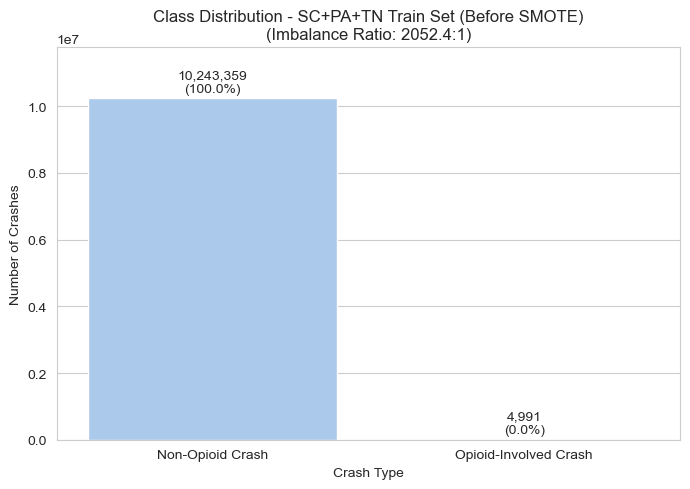


--- Applying SMOTE (Synthetic Minority Over-sampling Technique) ---
  SMOTE applied successfully.
  Shape before SMOTE: X=(10248350, 3), y=(10248350,)
  Shape after SMOTE:  X=(20486718, 3), y=(20486718,)

--- Plotting: Class Distribution - SC+PA+TN Train Set (After SMOTE) ---
  Saved plot: C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/D7\Dist_Train_AfterSMOTE_SC+PA+TN.png


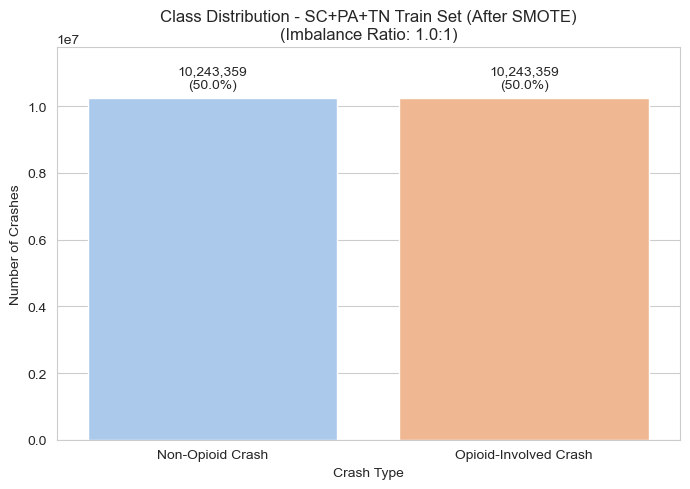

In [98]:
# PART 3: Data Splitting and Balancing (SMOTE)

print("\n" + "=" * 60)
print("# PART 3: Data Splitting and Balancing (SMOTE)")
print("=" * 60)

def split_data(df, target_col, features_list, test_size=0.3, val_size=0.5, random_state=42):
    """Splits data into train, validation, and test sets with stratification."""
    print("\n--- Splitting Data (70% Train / 15% Validation / 15% Test) ---")
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame.")
    if df[target_col].nunique() < 2:
         raise ValueError(f"Target variable '{target_col}' has < 2 unique classes. Cannot stratify.")

    missing_features = [f for f in features_list if f not in df.columns]
    if missing_features:
        raise ValueError(f"Missing feature columns for splitting: {missing_features}")

    X = df[features_list]
    y = df[target_col]

    # Check for NaNs before splitting
    if X.isnull().values.any() or y.isnull().values.any():
         print("Warning: NaN values detected before splitting. Dropping rows with NaNs in selected features/target.")
         df_cleaned = df[features_list + [target_col]].dropna()
         X = df_cleaned[features_list]
         y = df_cleaned[target_col]
         if df_cleaned.empty or y.nunique() < 2:
             raise ValueError("No data left after dropping NaNs or target has < 2 classes.")

    # Split into Train (70%) and Temp (30%)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)
    # Split Temp (30%) into Validation (15%) and Test (15%)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=val_size, random_state=random_state)

    print(f"Features: {features_list}")
    print(f"Target: {target_col}")
    print(f"Train shapes:      X={X_train.shape}, y={y_train.shape}")
    print(f"Validation shapes: X={X_val.shape}, y={y_val.shape}")
    print(f"Test shapes:       X={X_test.shape}, y={y_test.shape}")
    return X_train, X_val, X_test, y_train, y_val, y_test

def plot_class_distribution(y, title, filename=None):
    """Plots the class distribution with counts and imbalance ratio."""
    print(f"\n--- Plotting: {title} ---")
    if y is None or y.empty:
        print("  Cannot plot: Data is empty.")
        return
    counts = y.value_counts()
    total_count = len(y)
    if len(counts) < 2 or 1 not in counts.index or 0 not in counts.index or counts[1] == 0:
        imbalance = np.nan
        print(f"  Warning: Cannot calculate imbalance ratio (Needs 0 and 1 classes with non-zero count for class 1). Counts:\n{counts}")
    else:
        imbalance = counts[0] / counts[1]

    labels_map = {0: 'Non-Opioid Crash', 1: 'Opioid-Involved Crash'}
    plot_labels = [labels_map.get(i, f'Class {i}') for i in counts.index]

    plt.figure(figsize=(7, 5))
    ax = sns.barplot(x=plot_labels, y=counts.values, palette='pastel')

    # Add text labels (counts and percentages)
    for i, v in enumerate(counts.values):
        percentage = v / total_count * 100
        ax.text(i, v + (0.01 * total_count), f'{v:,}\n({percentage:.1f}%)', ha='center', va='bottom')

    title_text = f"{title}\n(Imbalance Ratio: {'{:.1f}:1'.format(imbalance) if not np.isnan(imbalance) else 'N/A'})"
    plt.title(title_text)
    plt.ylabel('Number of Crashes')
    plt.xlabel('Crash Type')
    plt.ylim(0, counts.max() * 1.15) # Adjust y-limit for text space
    plt.tight_layout()

    if filename:
        try:
            filepath = os.path.join(output_path, filename)
            # --- ADDED dpi=300 ---
            plt.savefig(filepath, dpi=300)
            # ---------------------
            print(f"  Saved plot: {filepath}")
        except Exception as e:
            print(f"  Error saving plot {filename}: {e}")
    plt.show()

def apply_smote(X_train, y_train, random_state=42):
    """Applies SMOTE to balance the training data."""
    print("\n--- Applying SMOTE (Synthetic Minority Over-sampling Technique) ---")
    minority_class_count = y_train.value_counts().min()
    n_neighbors = 5 # Default k_neighbors for SMOTE

    if minority_class_count <= n_neighbors:
        print(f"  Warning: Minority class has only {minority_class_count} samples.")
        if minority_class_count <= 1:
            print("  ERROR: Cannot apply SMOTE with <= 1 minority sample. Returning original data.")
            return X_train, y_train
        n_neighbors = minority_class_count - 1 # Adjust k_neighbors
        print(f"  Adjusting SMOTE k_neighbors to {n_neighbors}.")

    sm = SMOTE(random_state=random_state, k_neighbors=n_neighbors)
    try:
        X_res, y_res = sm.fit_resample(X_train, y_train)
        print("  SMOTE applied successfully.")
        print(f"  Shape before SMOTE: X={X_train.shape}, y={y_train.shape}")
        print(f"  Shape after SMOTE:  X={X_res.shape}, y={y_res.shape}")
        return X_res, y_res
    except Exception as e:
        print(f"  Error during SMOTE: {e}. Returning original training data.")
        return X_train, y_train

# --- Define Features and Target ---
features = ['driver_age', 'alcohol_flag', 'any_drug_flag']
target = 'opioid_flag'

# --- Perform Split ---
X_train, X_val, X_test, y_train, y_val, y_test = split_data(analysis_df, target, features, random_state=random_seed)

# --- Visualize Distribution Before SMOTE ---
plot_class_distribution(y_train, f"Class Distribution - {current_dataset_name} Train Set (Before SMOTE)",
                        filename=f'Dist_Train_BeforeSMOTE_{current_dataset_name}.png')

# --- Apply SMOTE ---
X_train_res, y_train_res = apply_smote(X_train, y_train, random_state=random_seed)

# --- Visualize Distribution After SMOTE ---
plot_class_distribution(y_train_res, f"Class Distribution - {current_dataset_name} Train Set (After SMOTE)",
                        filename=f'Dist_Train_AfterSMOTE_{current_dataset_name}.png')

This section builds and evaluates three classification models (Logistic Regression,
Random Forest, XGBoost) + one heuristic model (rule-based) + a regression model.
It outputs metrics, confusion matrices, ROC curves, and summary tables.


# PART 4: Model Training and Evaluation

### Overview
This section trains and evaluates several models to predict opioid involvement:
1.  **Classification Models:** Logistic Regression, Random Forest, XGBoost trained on SMOTE-balanced data.
2.  **Heuristic Model:** A simple rule-based model for baseline comparison.
3.  **Regression Model:** A Linear Regression model attempting to predict the binary flag (non-standard, included for comparison as requested), evaluated with R², RMSE, and MAE.

Models are evaluated on the original (unbalanced) validation set.


--- Validation Set Class Distribution Check ---
Value Counts:
 opioid_flag
0    2195005
1       1070
Name: count, dtype: int64

Validation set contains 2 classes. Minority class count: 1070. Proceeding with evaluation.

--- Evaluating Classification Models on 'SC+PA+TN' ---

--- Training and Evaluating: Logistic Regression ---
  Confusion Matrix (Validation Set):
[[2182107   12898]
 [    319     751]]
  Accuracy:  0.9940
  Precisio

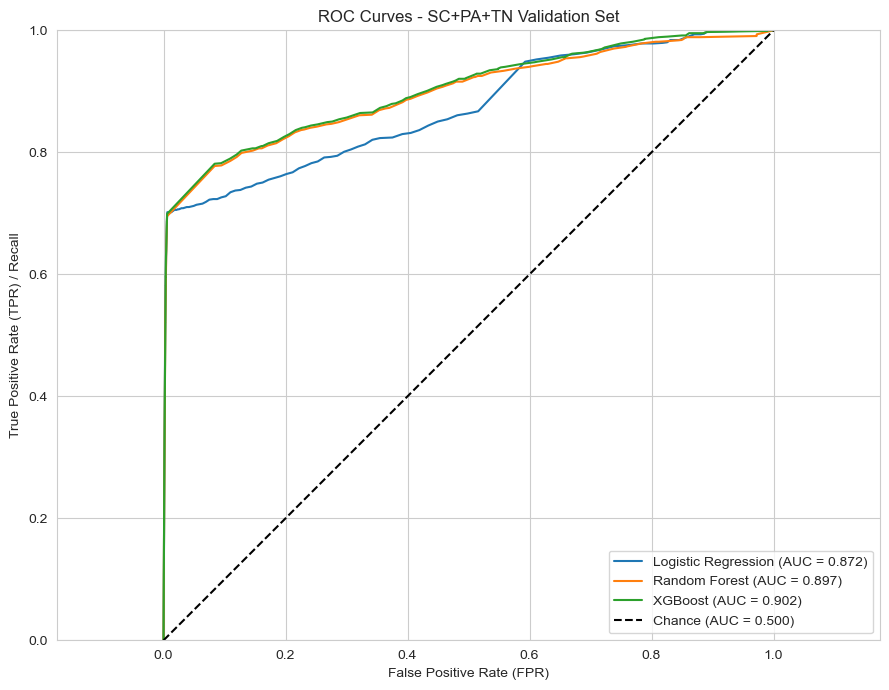


--- Evaluating Heuristic Model ---
  Rule: Predict opioid_flag=1 if (any_drug_flag=1 OR alcohol_flag=1)
  Accuracy:  0.9836
  Precision: 0.0206
  Recall:    0.7019
  F1-score:  0.0401
  AUC:       0.8428
  Added 'Heuristic (Any Drug/Alcohol)' to leaderboard.

--- Evaluating: Linear Regression (on Binary Target) ---
           not statistically appropriate. Predictions are not probabilities
           and can fall outside [0, 1]. Metrics (R², RMSE, MAE) should be
           interpreted with extreme caution in this context.
  R² score: -120.5005
  RMSE:     0.2432
  MAE:      0.2352
  Added 'Linear Regression (on Binary Target)' to leaderboard.


In [99]:
# PART 4: Model Training and Evaluation

print("\n" + "=" * 60)
print("# PART 4: Model Training and Evaluation")
print("=" * 60)
print("""
### Overview
This section trains and evaluates several models to predict opioid involvement:
1.  **Classification Models:** Logistic Regression, Random Forest, XGBoost trained on SMOTE-balanced data.
2.  **Heuristic Model:** A simple rule-based model for baseline comparison.
3.  **Regression Model:** A Linear Regression model attempting to predict the binary flag (non-standard, included for comparison as requested), evaluated with R², RMSE, and MAE.

Models are evaluated on the original (unbalanced) validation set.
""")

# --- !!!VALIDATION CHECK!!! ---
print("\n--- Validation Set Class Distribution Check ---")
# First, ensure y_val exists (it should if PART 3 ran correctly)
if 'y_val' in locals() or 'y_val' in globals():
    print("Value Counts:\n", y_val.value_counts())
    if y_val.nunique() < 2:
        print("\nWARNING: Validation set contains only one class! Classification metrics (AUC, Precision, Recall, F1) may be NaN or 0 due to lack of samples from the minority class.")
    else:
        minority_count = y_val.value_counts().min()
        print(f"\nValidation set contains {y_val.nunique()} classes. Minority class count: {minority_count}. Proceeding with evaluation.")
else:
     print("\nERROR: y_val variable not found. Cannot check validation distribution. Did PART 3 run correctly?")
     # Optionally exit or raise an error if y_val is critical and missing

# --- Initialize Leaderboard ---
model_leaderboard = []

def add_to_leaderboard(model_name, dataset_name, metrics_dict):
    """Adds model performance metrics to the leaderboard list."""
    entry = {'Model': model_name, 'Dataset': dataset_name}
    # Format metrics to avoid excessive decimal places, handle None/NA
    def fmt(val, digits=4):
        return round(val, digits) if pd.notna(val) else 'NA'

    entry['Accuracy'] = fmt(metrics_dict.get('Accuracy'))
    entry['Precision'] = fmt(metrics_dict.get('Precision'))
    entry['Recall'] = fmt(metrics_dict.get('Recall'))
    entry['F1 Score'] = fmt(metrics_dict.get('F1'))
    entry['AUC'] = fmt(metrics_dict.get('AUC'))
    entry['R²'] = fmt(metrics_dict.get('R2')) if metrics_dict.get('R2') is not None else 'NA'
    entry['RMSE'] = fmt(metrics_dict.get('RMSE')) if metrics_dict.get('RMSE') is not None else 'NA'
    entry['MAE'] = fmt(metrics_dict.get('MAE')) if metrics_dict.get('MAE') is not None else 'NA'
    model_leaderboard.append(entry)
    print(f"  Added '{model_name}' to leaderboard.")


def evaluate_classification_models(X_train, y_train, X_val, y_val, dataset_name, random_state=42): # <-- Added random_state parameter
    """Trains, evaluates classification models, and plots ROC curves."""
    print(f"\n--- Evaluating Classification Models on '{dataset_name}' ---")
    models = {
        # Ensure models inside use the passed random_state
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=random_state),
        'Random Forest': RandomForestClassifier(random_state=random_state),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state)
    }
    trained_models = {}
    plt.figure(figsize=(9, 7)) # Create figure for combined ROC plot

    for name, model in models.items():
        print(f"\n--- Training and Evaluating: {name} ---")
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            y_proba = model.predict_proba(X_val)[:, 1] # Probability of class 1

            metrics = {}
            metrics['Accuracy'] = accuracy_score(y_val, y_pred)
            metrics['Precision'] = precision_score(y_val, y_pred, zero_division=0)
            metrics['Recall'] = recall_score(y_val, y_pred, zero_division=0)
            metrics['F1'] = f1_score(y_val, y_pred, zero_division=0)
            metrics['AUC'] = roc_auc_score(y_val, y_proba) if len(np.unique(y_val)) > 1 else np.nan

            cm = confusion_matrix(y_val, y_pred)
            print("  Confusion Matrix (Validation Set):")
            print(cm)
            print(f"  Accuracy:  {metrics['Accuracy']:.4f}")
            print(f"  Precision: {metrics['Precision']:.4f}")
            print(f"  Recall:    {metrics['Recall']:.4f}")
            print(f"  F1-score:  {metrics['F1']:.4f}")
            print(f"  AUC:       {metrics['AUC']:.4f}" if pd.notna(metrics['AUC']) else "  AUC: N/A")

            add_to_leaderboard(name, dataset_name, metrics)
            trained_models[name] = model # Store the trained model

            # Plot ROC curve for this model
            if pd.notna(metrics['AUC']):
                fpr, tpr, _ = roc_curve(y_val, y_proba)
                plt.plot(fpr, tpr, label=f"{name} (AUC = {metrics['AUC']:.3f})")

        except Exception as e:
            print(f"  ERROR training/evaluating {name}: {e}")
            add_to_leaderboard(name, dataset_name, {}) # Add empty metrics

    # Finalize combined ROC plot
    plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.500)') # Reference line
    plt.title(f"ROC Curves - {dataset_name} Validation Set")
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR) / Recall')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.axis('equal') # Ensure square aspect ratio for better visual comparison
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.tight_layout()
    roc_filename = f'ROC_Curves_{dataset_name}.png'
    try:
        filepath = os.path.join(output_path, roc_filename)
        plt.savefig(filepath)
        print(f"\nSaved combined ROC plot: {filepath}")
    except Exception as e:
        print(f"  Error saving ROC plot: {e}")
    plt.show()

    return trained_models

def heuristic_model(X_val, y_val, dataset_name):
    """Evaluates a simple heuristic model."""
    print("\n--- Evaluating Heuristic Model ---")
    # Heuristic: Predict opioid involvement if *any* drug or alcohol flag is set.
    # Note: More complex rules could involve age thresholds or specific drug combinations.
    print("  Rule: Predict opioid_flag=1 if (any_drug_flag=1 OR alcohol_flag=1)")
    preds = ((X_val['any_drug_flag'] == 1) | (X_val['alcohol_flag'] == 1)).astype(int)

    metrics = {}
    metrics['Accuracy'] = accuracy_score(y_val, preds)
    metrics['Precision'] = precision_score(y_val, preds, zero_division=0)
    metrics['Recall'] = recall_score(y_val, preds, zero_division=0)
    metrics['F1'] = f1_score(y_val, preds, zero_division=0)
    # Use predictions directly for AUC calculation (lower bound performance)
    metrics['AUC'] = roc_auc_score(y_val, preds) if len(np.unique(y_val)) > 1 else np.nan

    print(f"  Accuracy:  {metrics['Accuracy']:.4f}")
    print(f"  Precision: {metrics['Precision']:.4f}")
    print(f"  Recall:    {metrics['Recall']:.4f}")
    print(f"  F1-score:  {metrics['F1']:.4f}")
    print(f"  AUC:       {metrics['AUC']:.4f}" if pd.notna(metrics['AUC']) else "  AUC: N/A")

    add_to_leaderboard("Heuristic (Any Drug/Alcohol)", dataset_name, metrics)
    return preds # Return predictions if needed


def regression_model_eval(X_train, y_train, X_val, y_val, dataset_name, random_state=42):
    """Evaluates Linear Regression for predicting the binary target."""

    # --- FIX: Define model_name *before* the try block ---
    model_name = "Linear Regression (on Binary Target)"
    # ----------------------------------------------------

    print(f"\n--- Evaluating: {model_name} ---") # You can use the variable here too
    print("  WARNING: Applying linear regression to a binary (0/1) target is generally")
    print("           not statistically appropriate. Predictions are not probabilities")
    print("           and can fall outside [0, 1]. Metrics (R², RMSE, MAE) should be")
    print("           interpreted with extreme caution in this context.")

    reg = LinearRegression() # Defined before try block

    metrics = {}
    trained_model = None
    y_pred_reg = None

    try:
        reg.fit(X_train, y_train)
        y_pred_reg = reg.predict(X_val) # Continuous predictions

        # Check if y_val has enough samples/variance for metrics
        if y_val.nunique() < 2:
             print("  Skipping R2/RMSE/MAE calculation: y_val has only one unique value.")
             # Ensure keys exist even if skipped
             metrics['R2'], metrics['RMSE'], metrics['MAE'] = np.nan, np.nan, np.nan
        else:
            metrics['R2'] = r2_score(y_val, y_pred_reg)
            metrics['RMSE'] = np.sqrt(mean_squared_error(y_val, y_pred_reg))
            # If the NameError for mean_absolute_error was fixed by import, this should work
            metrics['MAE'] = mean_absolute_error(y_val, y_pred_reg) # Added MAE

            print(f"  R² score: {metrics['R2']:.4f}")
            print(f"  RMSE:     {metrics['RMSE']:.4f}")
            print(f"  MAE:      {metrics['MAE']:.4f}") # Print MAE

        trained_model = reg

    except Exception as e:
        # --- FIX: Now model_name is defined and can be used safely ---
        print(f"  ERROR training/evaluating {model_name}: {e}")
        # Ensure metrics dictionary contains keys even if calculation failed, set to NaN
        metrics.setdefault('R2', np.nan)
        metrics.setdefault('RMSE', np.nan)
        metrics.setdefault('MAE', np.nan)
        # -------------------------------------------------------------

    # Add to leaderboard regardless of success (NA for failed metrics)
    # --- FIX: Use model_name variable for consistency ---
    add_to_leaderboard(model_name, dataset_name, metrics)
    # -------------------------------------------------

    return trained_model, y_pred_reg # Return model and its predictions

    # Add to leaderboard regardless of success (NA for failed metrics)
    add_to_leaderboard(model_name, dataset_name, metrics)
    return trained_model, y_pred_reg # Return model and its predictions


# --- Run Model Evaluations ---
# Use SMOTE'd data for training classifiers, original validation set for evaluation
trained_classification_models = evaluate_classification_models(X_train_res, y_train_res, X_val, y_val, current_dataset_name, random_state=random_seed) # Change random_seed= to random_state=

# Evaluate Heuristic model
heuristic_preds = heuristic_model(X_val, y_val, current_dataset_name)

# Evaluate Regression model (use SMOTE'd data for consistency, though issue remains)
trained_regression_model, y_pred_regression = regression_model_eval(X_train_res, y_train_res, X_val, y_val, current_dataset_name, random_state=random_seed)

This section adds explainability with SHAP, feature importance visualizations,
correlation heatmaps to show relationships between variables, and residual plots 
to evaluate regression model fit.


# PART 5: Model Explainability and Feature Analysis

### Overview
This section delves into understanding the model predictions and feature relationships:
1.  **Feature Importance:** Ranks features based on their contribution to the predictions of tree-based models (e.g., XGBoost) or coefficient magnitude for linear models.
2.  **Correlation Analysis:** Visualizes the linear correlation between input features.
3.  **SHAP Explanations:** Provides detailed insights into how each feature influences the prediction for individual instances using the SHAP (SHapley Additive exPlanations) framework.
4.  **Residual Analysis:** Examines the difference between actual and predicted values, primarily for the regression model.


--- Plotting Feature Correlation Heatmap (SC+PA+TN_TrainFeatures) ---
  Saved plot: C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/D7\Correlation_Heatmap_SC+PA+TN_TrainFeatures.png


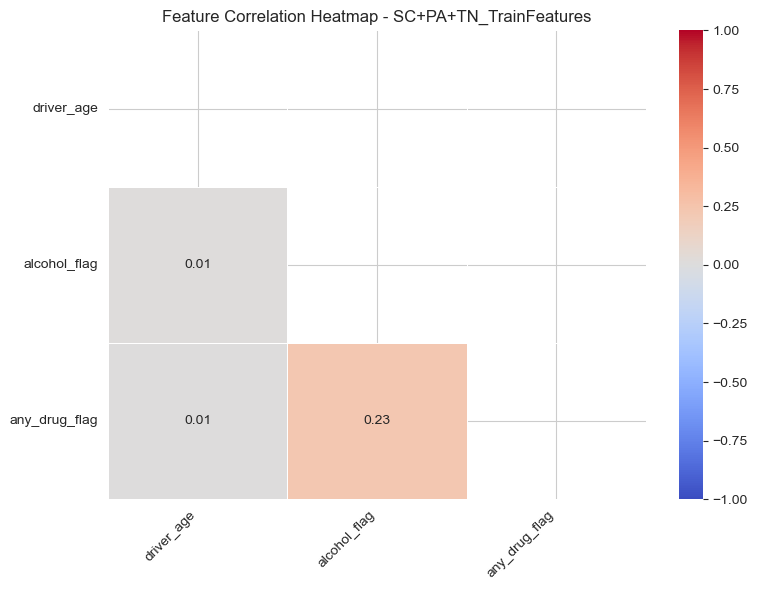


--- Generating Detailed Explanations for Model: XGBoost ---

--- Plotting Feature Importance: XGBoost ---
  Saved plot: C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/D7\Feature_Importance_XGBoost_SC+PA+TN.png


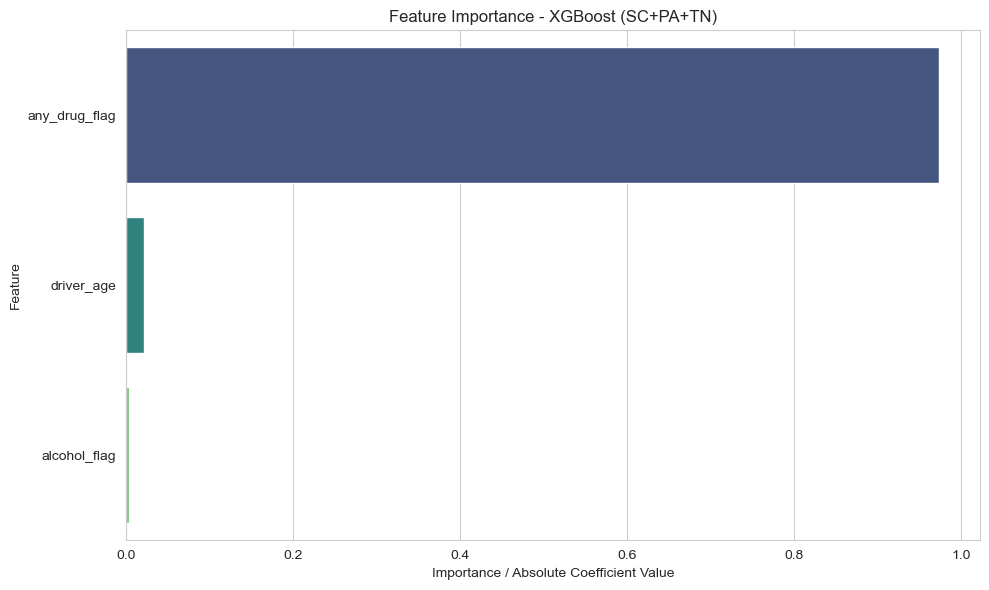


--- Generating SHAP Summary Plot: XGBoost ---
  Note: SHAP calculation can be time-consuming for large datasets or complex models.
  Saved plot: C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/D7\SHAP_Summary_XGBoost_SC+PA+TN.png


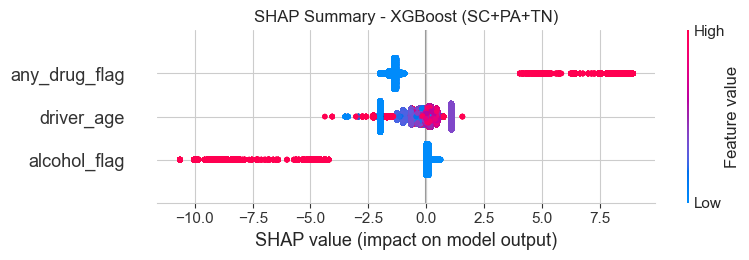


--- Plotting Feature Importance: Logistic Regression ---
  Saved plot: C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/D7\Feature_Importance_Logistic_Regression_SC+PA+TN.png


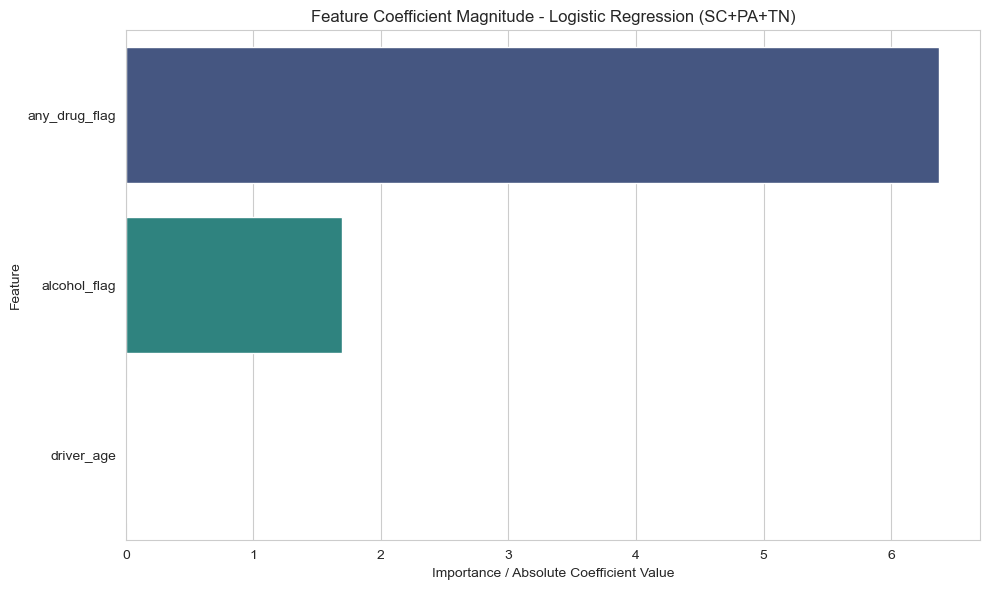


--- Residual Analysis for Linear Regression (on Binary Target) ---
  Reminder: Interpreting residuals for a model predicting a binary target
            with linear regression is non-standard. Expect distinct bands.

--- Plotting Residuals: Linear Regression (on Binary Target) ---
  Saved plot: C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/D7\Residual_Plot_Linear_Regression_(on_Binary_Target)_SC+PA+TN.png


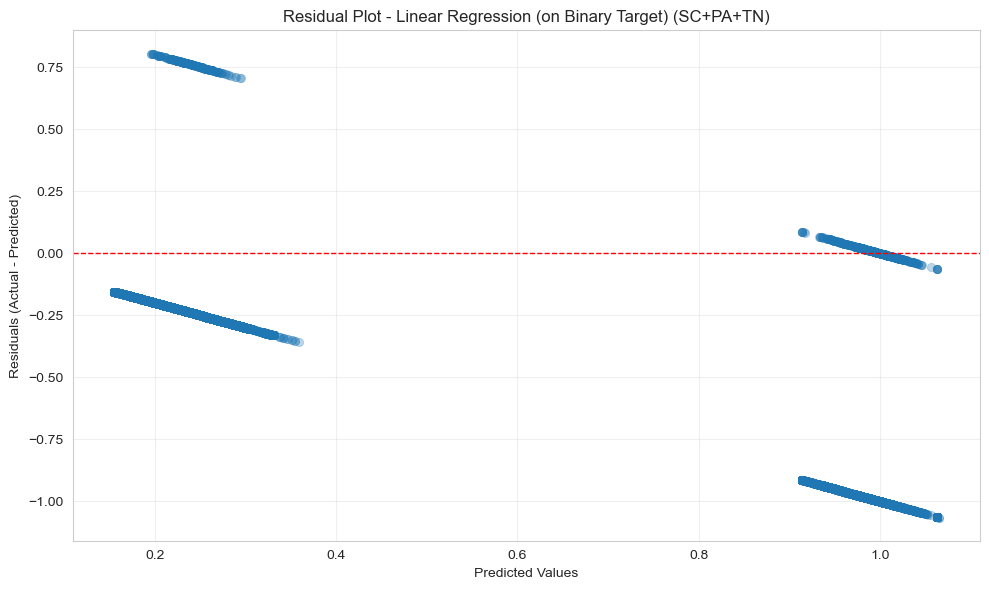

In [100]:
# PART 5: Model Explainability and Feature Analysis

print("\n" + "=" * 60)
print("# PART 5: Model Explainability and Feature Analysis")
print("=" * 60)
print("""
### Overview
This section delves into understanding the model predictions and feature relationships:
1.  **Feature Importance:** Ranks features based on their contribution to the predictions of tree-based models (e.g., XGBoost) or coefficient magnitude for linear models.
2.  **Correlation Analysis:** Visualizes the linear correlation between input features.
3.  **SHAP Explanations:** Provides detailed insights into how each feature influences the prediction for individual instances using the SHAP (SHapley Additive exPlanations) framework.
4.  **Residual Analysis:** Examines the difference between actual and predicted values, primarily for the regression model.
""")

def plot_feature_importance(model, X_cols, model_name, dataset_name):
    """Plots feature importances for tree models or coefficients for linear models."""
    print(f"\n--- Plotting Feature Importance: {model_name} ---")
    importances = None
    plot_title = f'Feature Importance - {model_name} ({dataset_name})'

    if hasattr(model, 'feature_importances_'): # Tree-based models (RF, XGBoost)
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        features = X_cols[indices]
        importances = importances[indices]
    elif hasattr(model, 'coef_'): # Linear models (Logistic Regression, Linear Regression)
        if model.coef_.ndim > 1: # Handle multi-class coef_ shape if needed, assuming binary (shape [1, n_features])
            importances = np.abs(model.coef_[0])
        else:
             importances = np.abs(model.coef_)
        indices = np.argsort(importances)[::-1]
        features = X_cols[indices]
        importances = importances[indices]
        plot_title = f'Feature Coefficient Magnitude - {model_name} ({dataset_name})'
    else:
        print(f"  Feature importance/coefficients not directly available for model type: {type(model)}")
        return

    plt.figure(figsize=(10, max(6, len(features)*0.5))) # Adjust height based on num features
    sns.barplot(x=importances, y=features, palette='viridis', orient='h')
    plt.title(plot_title)
    plt.xlabel('Importance / Absolute Coefficient Value')
    plt.ylabel('Feature')
    plt.tight_layout()
    fi_filename = f'Feature_Importance_{model_name}_{dataset_name}.png'.replace(" ", "_")
    try:
        filepath = os.path.join(output_path, fi_filename)
        plt.savefig(filepath)
        print(f"  Saved plot: {filepath}")
    except Exception as e:
        print(f"  Error saving plot: {e}")
    plt.show()

def plot_correlation_heatmap(df, features_list, dataset_name):
    """Plots a heatmap of the correlation matrix for specified features."""
    print(f"\n--- Plotting Feature Correlation Heatmap ({dataset_name}) ---")
    if not features_list or df[features_list].empty:
        print("  No features provided or data empty for correlation heatmap.")
        return

    # Ensure only numeric columns are used
    numeric_features = df[features_list].select_dtypes(include=np.number).columns
    if len(numeric_features) < 2:
        print(f"  Not enough numeric features ({len(numeric_features)}) to calculate correlation.")
        return

    plt.figure(figsize=(8, 6))
    corr = df[numeric_features].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool)) # Mask for upper triangle
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, mask=mask, vmin=-1, vmax=1)
    plt.title(f'Feature Correlation Heatmap - {dataset_name}')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    corr_filename = f'Correlation_Heatmap_{dataset_name}.png'.replace(" ", "_")
    try:
        filepath = os.path.join(output_path, corr_filename)
        plt.savefig(filepath)
        print(f"  Saved plot: {filepath}")
    except Exception as e:
        print(f"  Error saving plot: {e}")
    plt.show()


def plot_shap_summary(model, X_data, X_cols, model_name, dataset_name):
    """Generates and plots SHAP summary plots."""
    print(f"\n--- Generating SHAP Summary Plot: {model_name} ---")
    print("  Note: SHAP calculation can be time-consuming for large datasets or complex models.")
    try:
        # Use appropriate explainer based on model type
        if isinstance(model, (RandomForestClassifier, XGBClassifier)):
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_data) # Can return list for multi-class
        elif isinstance(model, LogisticRegression):
            explainer = shap.LinearExplainer(model, X_data)
            shap_values = explainer.shap_values(X_data) # Usually single array for binary
        elif isinstance(model, LinearRegression):
             # Linear regression explanation
             explainer = shap.LinearExplainer(model, X_data)
             shap_values = explainer.shap_values(X_data)
        else:
            print(f"  Warning: Using KernelExplainer for {type(model)}, which can be slow.")
             # Fallback to KernelExplainer (approximates SHAP values)
             # Needs predict_proba for classifiers, predict for regressors
            if hasattr(model, 'predict_proba'):
                 explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_data, 50)) # Sample for speed
                 shap_values = explainer.shap_values(X_data)[1] # Probability of class 1
            else:
                 explainer = shap.KernelExplainer(model.predict, shap.sample(X_data, 50)) # Sample for speed
                 shap_values = explainer.shap_values(X_data)

        # Handle different SHAP value structures (e.g., lists from TreeExplainer for multi-class)
        # For binary classification, we typically want explanation for class 1.
        shap_values_for_plot = shap_values
        plot_title = f"SHAP Summary - {model_name} ({dataset_name})"

        if isinstance(shap_values, list) and len(shap_values) == 2: # Binary classification case for TreeExplainer
            shap_values_for_plot = shap_values[1] # Index 1 corresponds to the positive class (opioid_flag=1)
            print("  Using SHAP values for the positive class (Opioid=1).")
            plot_title += " (Impact on Opioid=1 Prediction)"
        elif isinstance(explainer, shap.LinearExplainer) and model_name.startswith("Logistic"):
             plot_title += " (Log-Odds)" # Linear/Logistic explainers often work on log-odds scale

        # Generate the summary plot
        plt.figure()
        shap.summary_plot(shap_values_for_plot, X_data, feature_names=X_cols, show=False, plot_type='dot')
        plt.title(plot_title)
        plt.tight_layout()
        shap_filename = f'SHAP_Summary_{model_name}_{dataset_name}.png'.replace(" ", "_")
        filepath = os.path.join(output_path, shap_filename)
        plt.savefig(filepath)
        print(f"  Saved plot: {filepath}")
        plt.show()

    except Exception as e:
        print(f"  ERROR generating SHAP plot for {model_name}: {e}")
        # import traceback
        # traceback.print_exc() # Uncomment for detailed debugging trace


def plot_residuals(y_true, y_pred, model_name, dataset_name):
    """Plots residuals (true - predicted) vs. predicted values."""
    print(f"\n--- Plotting Residuals: {model_name} ---")
    if y_pred is None:
         print("  Cannot plot residuals: Predictions are missing.")
         return

    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    # Use scatterplot with some transparency
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.3, edgecolor=None)
    plt.axhline(0, linestyle='--', color='red', lw=1)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.title(f'Residual Plot - {model_name} ({dataset_name})')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    res_filename = f'Residual_Plot_{model_name}_{dataset_name}.png'.replace(" ", "_")
    try:
        filepath = os.path.join(output_path, res_filename)
        plt.savefig(filepath)
        print(f"  Saved plot: {filepath}")
    except Exception as e:
        print(f"  Error saving plot: {e}")
    plt.show()


# --- Run Feature Analysis and Explainability ---

# Correlation Heatmap (using original training features)
plot_correlation_heatmap(X_train, features, f"{current_dataset_name}_TrainFeatures")

# Choose best/representative model for detailed explanation (e.g., XGBoost)
# You could automate choosing the best model based on a metric from the leaderboard
chosen_model_name = 'XGBoost' # Example
if chosen_model_name in trained_classification_models:
    print(f"\n--- Generating Detailed Explanations for Model: {chosen_model_name} ---")
    model_to_explain = trained_classification_models[chosen_model_name]
    # Feature Importance
    plot_feature_importance(model_to_explain, X_val.columns, chosen_model_name, current_dataset_name)
    # SHAP Plot (using validation data for explanation)
    # Use a smaller sample if X_val is very large and SHAP is slow
    X_val_sample = X_val # shap.sample(X_val, 200) if len(X_val) > 1000 else X_val
    plot_shap_summary(model_to_explain, X_val_sample, X_val.columns, chosen_model_name, current_dataset_name)
else:
    print(f"\nChosen model for explanation ('{chosen_model_name}') not found in trained models. Skipping detailed plots.")

# Also show feature importance for Logistic Regression if trained
if 'Logistic Regression' in trained_classification_models:
     plot_feature_importance(trained_classification_models['Logistic Regression'], X_val.columns, 'Logistic Regression', current_dataset_name)


# Residual Plot for the Linear Regression model
if trained_regression_model and y_pred_regression is not None:
    print("\n--- Residual Analysis for Linear Regression (on Binary Target) ---")
    print("  Reminder: Interpreting residuals for a model predicting a binary target")
    print("            with linear regression is non-standard. Expect distinct bands.")
    plot_residuals(y_val, y_pred_regression, "Linear Regression (on Binary Target)", current_dataset_name)

This section simulates financial cost reductions from interventions, visualizes 
ROI by county, and produces a heatmap of crash costs over time across counties. 
These help translate model insights into real business impact.


# PART 6: Business Impact Analysis

### Overview
This section estimates the potential financial implications of crashes and the
potential return on investment (ROI) from interventions aimed at reducing
opioid-involved crashes. It uses the predefined crash cost mapping.
1.  **Cost Calculation:** Estimates cost for each crash based on severity.
2.  **Financial Simulation:** Shows total baseline cost vs. cost after a hypothetical intervention effectiveness (e.g., 10% reduction).
3.  **ROI by County:** Estimates ROI assuming a fixed intervention cost per crash and the hypothetical effectiveness, highlighting counties with potentially higher returns.
4.  **Cost Heatmap:** Visualizes the distribution of total crash costs across counties and years.


--- Calculating Estimated Crash Costs ---
  Applied cost mapping. Default cost ($20,000) used for 0 crashes (due to NaN or unmapped severity).
  Example costs:  severity_level  estimated_crash_cost
              4                 27000
         

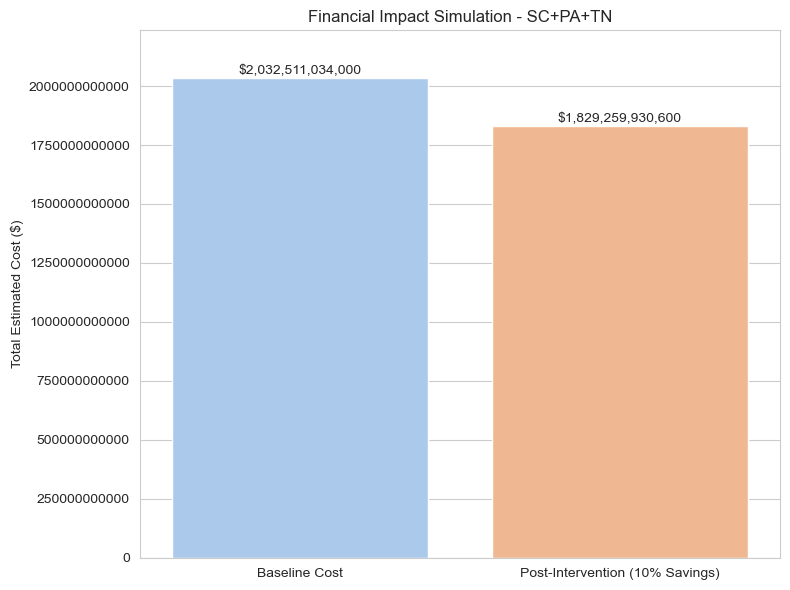

  Baseline Total Estimated Cost: $2,032,511,034,000.00
  Simulated Post-Intervention Cost (10% reduction): $1,829,259,930,600.00
  Simulated Savings: $203,251,103,400.00

--- Plotting Simulated ROI by County ---
  Assumptions: 10% Cost Reduction Effectiveness, $500/Crash Intervention Cost
  Saved plot: C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/D7\ROI_by_County_SC+PA+TN.png


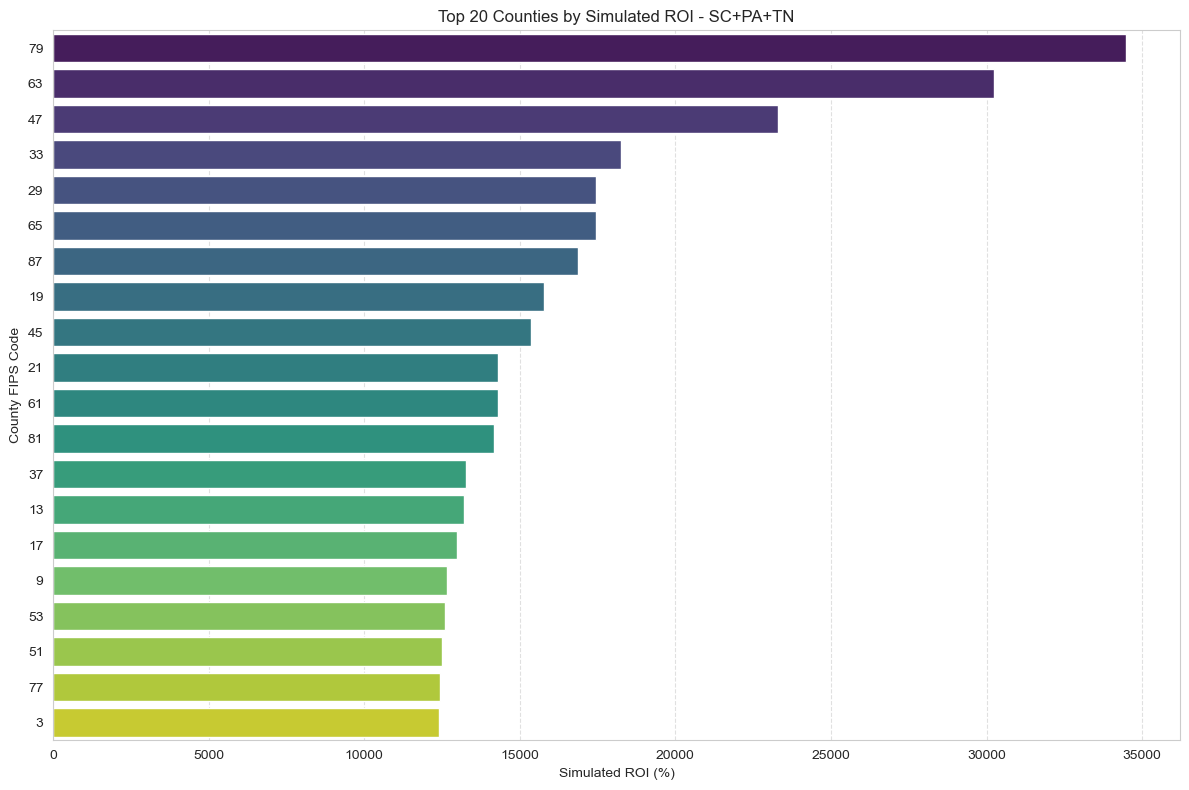

  County ROI summary saved to: C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/D7\County_ROI_Summary_SC+PA+TN.csv

--- Plotting Cost Heatmap (County vs. Year) ---
  Saved plot: C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/D7\Cost_Heatmap_County_Year_SC+PA+TN.png


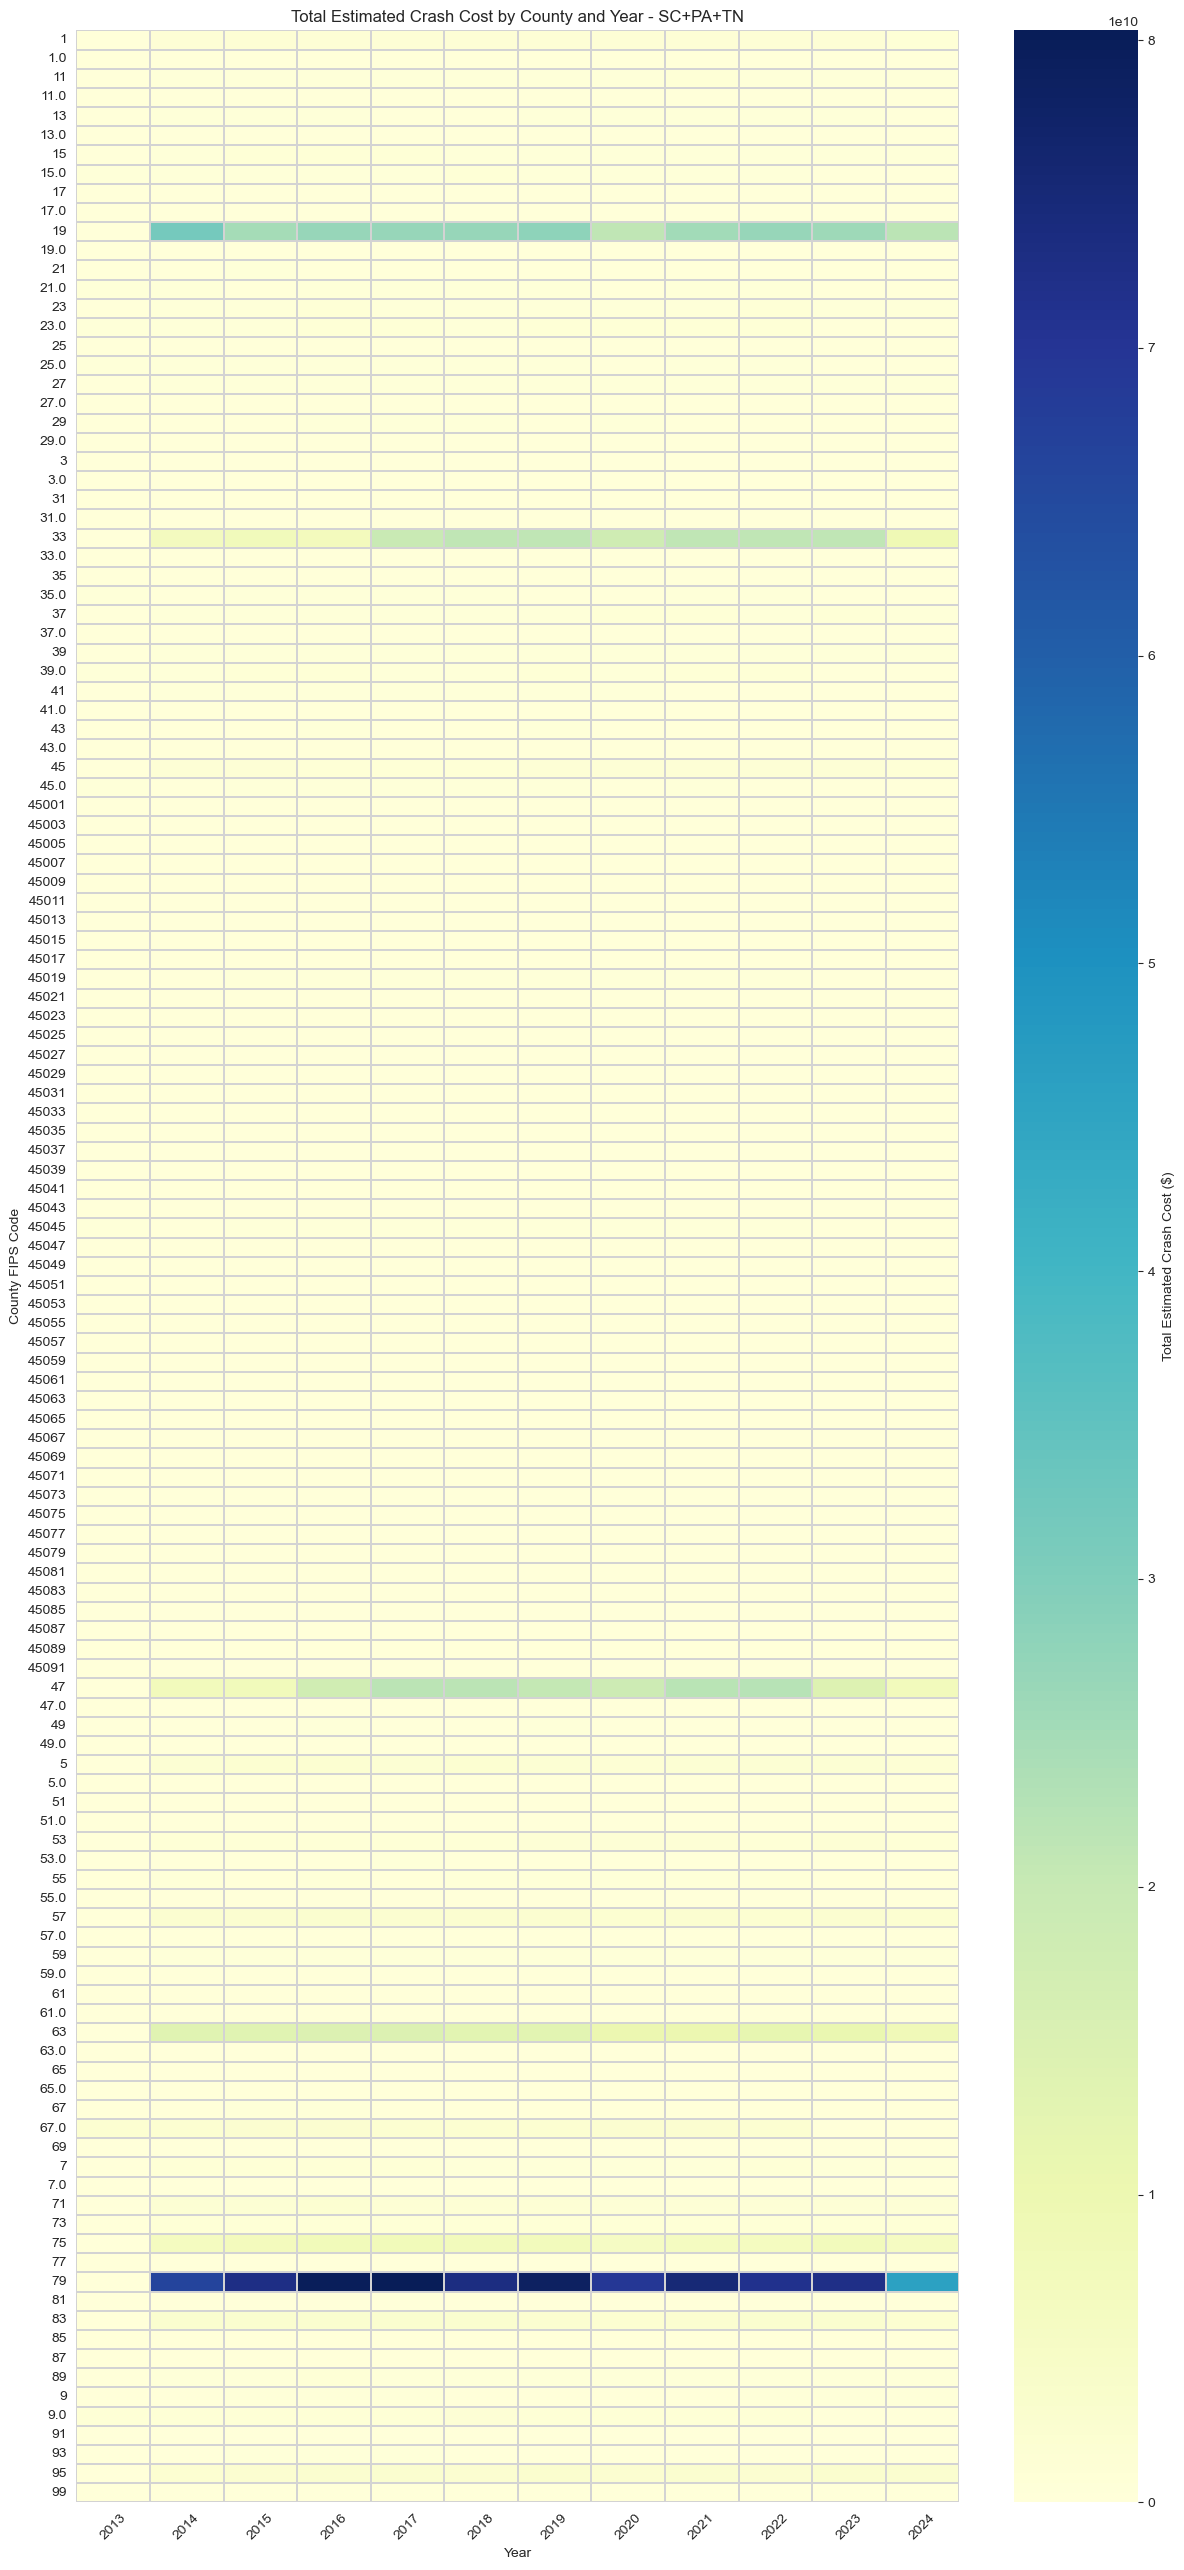

In [101]:
# PART 6: Financial Impact, ROI, Heatmaps

print("\n" + "=" * 60)
print("# PART 6: Business Impact Analysis")
print("=" * 60)
print("""
### Overview
This section estimates the potential financial implications of crashes and the
potential return on investment (ROI) from interventions aimed at reducing
opioid-involved crashes. It uses the predefined crash cost mapping.
1.  **Cost Calculation:** Estimates cost for each crash based on severity.
2.  **Financial Simulation:** Shows total baseline cost vs. cost after a hypothetical intervention effectiveness (e.g., 10% reduction).
3.  **ROI by County:** Estimates ROI assuming a fixed intervention cost per crash and the hypothetical effectiveness, highlighting counties with potentially higher returns.
4.  **Cost Heatmap:** Visualizes the distribution of total crash costs across counties and years.
""")

def calculate_crash_cost(df, cost_mapping):
    """Calculates estimated crash cost based on severity level."""
    print("\n--- Calculating Estimated Crash Costs ---")
    cost_col = 'estimated_crash_cost'
    severity_col = 'severity_level'

    if severity_col not in df.columns:
        print(f"  Error: '{severity_col}' column not found. Cannot calculate costs.")
        return df

    # Ensure severity is numeric, coerce errors, store original type if needed
    df[severity_col] = pd.to_numeric(df[severity_col], errors='coerce')

    # Map costs, fill NaNs (from coercion or unmapped levels) with a default/placeholder value
    default_cost = 20000 # Placeholder cost for unknown/missing severity
    df[cost_col] = df[severity_col].map(cost_mapping).fillna(default_cost)
    nan_sev_count = df[severity_col].isna().sum()
    mapped_nan_count = df[cost_col].isna().sum() # Should be 0 after fillna
    filled_count = (df[cost_col] == default_cost).sum() - (df[severity_col].map(cost_mapping) == default_cost).sum()


    print(f"  Applied cost mapping. Default cost (${default_cost:,.0f}) used for {nan_sev_count + filled_count:,} crashes (due to NaN or unmapped severity).")
    print(f"  Example costs: {df[[severity_col, cost_col]].head().to_string(index=False)}")
    print(f"  Total Estimated Cost (Sum): ${df[cost_col].sum():,.0f}")
    return df

def plot_financial_simulation(df, dataset_name, effectiveness=0.10):
    """Simulates and plots financial impact of an intervention."""
    print(f"\n--- Plotting Financial Simulation ({effectiveness*100:.0f}% Reduction Scenario) ---")
    cost_col = 'estimated_crash_cost'
    if cost_col not in df.columns:
        print("  Error: 'estimated_crash_cost' column not found.")
        return

    total_cost = df[cost_col].sum()
    savings = total_cost * effectiveness
    post_intervention_cost = total_cost - savings

    plt.figure(figsize=(8, 6))
    bars = sns.barplot(x=['Baseline Cost', f'Post-Intervention ({effectiveness*100:.0f}% Savings)'],
                       y=[total_cost, post_intervention_cost], palette='pastel')
    plt.title(f'Financial Impact Simulation - {dataset_name}')
    plt.ylabel('Total Estimated Cost ($)')
    plt.ticklabel_format(style='plain', axis='y') # Use plain numbers, not sci notation

    # Add cost labels on bars
    for bar in bars.patches:
        bars.annotate(f'${bar.get_height():,.0f}',
                      (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                      ha='center', va='center',
                      xytext=(0, 5), # Offset text slightly above bar
                      textcoords='offset points')

    plt.ylim(0, total_cost * 1.1) # Adjust ylim for text space
    plt.tight_layout()
    fin_sim_filename = f'Financial_Simulation_{dataset_name}.png'.replace(" ", "_")
    try:
        filepath = os.path.join(output_path, fin_sim_filename)
        plt.savefig(filepath)
        print(f"  Saved plot: {filepath}")
    except Exception as e:
        print(f"  Error saving plot: {e}")
    plt.show()

    print(f"  Baseline Total Estimated Cost: ${total_cost:,.2f}")
    print(f"  Simulated Post-Intervention Cost ({effectiveness*100:.0f}% reduction): ${post_intervention_cost:,.2f}")
    print(f"  Simulated Savings: ${savings:,.2f}")

def plot_roi_by_county(df, dataset_name, effectiveness=0.10, intervention_cost_per_crash=500, top_n=20):
    """Calculates and plots simulated ROI by county."""
    print(f"\n--- Plotting Simulated ROI by County ---")
    print(f"  Assumptions: {effectiveness*100:.0f}% Cost Reduction Effectiveness, ${intervention_cost_per_crash}/Crash Intervention Cost")

    cost_col = 'estimated_crash_cost'
    county_col = 'county_fips'
    id_col = 'crash_id'

    required_cols = [cost_col, county_col, id_col]
    if any(col not in df.columns for col in required_cols):
        print(f"  Error: Missing one or more required columns for ROI calculation: {required_cols}")
        return

    # Group by county, aggregate crashes and costs
    county_summary = df.groupby(county_col).agg(
        total_crashes=(id_col, 'nunique'),
        total_cost=(cost_col, 'sum')
    ).reset_index()

    # Simulate savings and costs
    county_summary['simulated_savings'] = county_summary['total_cost'] * effectiveness
    county_summary['simulated_intervention_cost'] = county_summary['total_crashes'] * intervention_cost_per_crash

    # Calculate ROI = (Savings - Cost) / Cost * 100
    # Avoid division by zero if intervention cost is 0
    county_summary['roi_percent'] = 100 * (county_summary['simulated_savings'] - county_summary['simulated_intervention_cost']) / (county_summary['simulated_intervention_cost'] + 1e-6) # Add small epsilon

    # Sort by ROI and select top N
    county_summary_sorted = county_summary.sort_values('roi_percent', ascending=False)
    county_summary_top = county_summary_sorted.head(top_n)

    if county_summary_top.empty:
        print("  No county data available for ROI plot.")
        return

    plt.figure(figsize=(12, 8))
    sns.barplot(x='roi_percent', y=county_col, data=county_summary_top, palette='viridis', orient='h')
    plt.title(f'Top {top_n} Counties by Simulated ROI - {dataset_name}')
    plt.xlabel('Simulated ROI (%)')
    plt.ylabel('County FIPS Code')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    roi_filename = f'ROI_by_County_{dataset_name}.png'.replace(" ", "_")
    try:
        filepath = os.path.join(output_path, roi_filename)
        plt.savefig(filepath)
        print(f"  Saved plot: {filepath}")
    except Exception as e:
        print(f"  Error saving plot: {e}")
    plt.show()

    # Save the full county summary table
    county_summary_filename = f'County_ROI_Summary_{dataset_name}.csv'.replace(" ", "_")
    try:
        filepath = os.path.join(output_path, county_summary_filename)
        county_summary_sorted.to_csv(filepath, index=False, float_format='%.2f')
        print(f"  County ROI summary saved to: {filepath}")
    except Exception as e:
        print(f"  Error saving county summary CSV: {e}")


def plot_cost_heatmap(df, dataset_name):
    """Plots a heatmap of total crash cost by county and year."""
    print(f"\n--- Plotting Cost Heatmap (County vs. Year) ---")

    cost_col = 'estimated_crash_cost'
    county_col = 'county_fips'
    date_col = 'crash_date'

    required_cols = [cost_col, county_col, date_col]
    if any(col not in df.columns for col in required_cols):
        print(f"  Error: Missing one or more required columns for heatmap: {required_cols}")
        return
    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        print(f"  Error: '{date_col}' column is not datetime type.")
        return

    # Prepare data: Ensure required columns have no NaNs, extract year
    df_hm = df.dropna(subset=required_cols).copy()
    df_hm['crash_year'] = df_hm[date_col].dt.year

    if df_hm.empty:
        print("  No valid data remaining for heatmap after handling NaNs.")
        return

    # Aggregate cost by county and year
    heatmap_data = df_hm.groupby([county_col, 'crash_year'])[cost_col].sum().unstack().fillna(0)

    if heatmap_data.empty:
        print("  No data available for cost heatmap after grouping.")
        return

    # Limit years or counties if heatmap is too large/sparse? (Optional)
    # Example: years_to_plot = sorted(heatmap_data.columns)[-5:] # Last 5 years
    # Example: counties_to_plot = heatmap_data.sum(axis=1).nlargest(30).index # Top 30 counties by total cost
    # heatmap_data = heatmap_data.loc[counties_to_plot, years_to_plot]

    plt.figure(figsize=(max(12, heatmap_data.shape[1] * 0.8), max(8, heatmap_data.shape[0] * 0.2))) # Dynamic sizing
    sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.2, linecolor='lightgrey',
                cbar_kws={'label': 'Total Estimated Crash Cost ($)'}, annot=False) # Annot=True likely too crowded
    plt.title(f'Total Estimated Crash Cost by County and Year - {dataset_name}')
    plt.xlabel('Year')
    plt.ylabel('County FIPS Code')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    heatmap_filename = f'Cost_Heatmap_County_Year_{dataset_name}.png'.replace(" ", "_")
    try:
        filepath = os.path.join(output_path, heatmap_filename)
        plt.savefig(filepath)
        print(f"  Saved plot: {filepath}")
    except Exception as e:
        print(f"  Error saving plot: {e}")
    plt.show()

# --- Run Business Impact Analysis ---
# Perform calculations on the full analysis dataset before splitting
analysis_df_with_cost = calculate_crash_cost(analysis_df.copy(), crash_cost_mapping)

if 'estimated_crash_cost' in analysis_df_with_cost.columns:
    plot_financial_simulation(analysis_df_with_cost, current_dataset_name)
    plot_roi_by_county(analysis_df_with_cost, current_dataset_name)
    plot_cost_heatmap(analysis_df_with_cost, current_dataset_name)
else:
    print("\nSkipping Financial Analysis plots due to missing 'estimated_crash_cost' column.")

This section creates a model leaderboard that tracks the performance of each 
model across key metrics: Accuracy, Precision, Recall, F1 Score, AUC, R², RMSE.
It also exports summary tables as CSV files for easy inclusion in reports.

In [102]:
# PART 7: Results Summary and Export

print("\n" + "=" * 60)
print("# PART 7: Results Summary and Export")
print("=" * 60)
print("""
### Overview
This final section compiles the performance metrics of all evaluated models
into a leaderboard table and exports it to a CSV file.
""")

def export_leaderboard(leaderboard_list, output_dir):
    """Exports the model leaderboard to a CSV file and prints it."""
    print("\n--- Model Performance Leaderboard ---")
    if not leaderboard_list:
        print("  Leaderboard is empty. No models were successfully evaluated.")
        return None

    leaderboard_df = pd.DataFrame(leaderboard_list)

    # Define sort order preference (e.g., AUC first, then F1, then Recall)
    sort_columns = ['AUC', 'F1 Score', 'Recall', 'Accuracy', 'R²', 'RMSE', 'MAE']
    valid_sort_cols = [col for col in sort_columns if col in leaderboard_df.columns]

    # Convert potential metrics to numeric for sorting, coercing errors for 'NA'
    for col in valid_sort_cols:
         # Check if column is not already numeric
         if not pd.api.types.is_numeric_dtype(leaderboard_df[col]):
              leaderboard_df[col] = pd.to_numeric(leaderboard_df[col], errors='coerce')

    # Sort by multiple columns (handle potential NaNs by filling them temporarily for sorting)
    # Higher is better for AUC, F1, Recall, Accuracy, R^2
    # Lower is better for RMSE, MAE
    ascending_map = {
        'AUC': False, 'F1 Score': False, 'Recall': False, 'Accuracy': False, 'R²': False,
        'RMSE': True, 'MAE': True
    }
    sort_cols_present = [col for col in sort_columns if col in leaderboard_df.columns]
    ascending_order = [ascending_map.get(col, False) for col in sort_cols_present]

    try:
        leaderboard_df_sorted = leaderboard_df.sort_values(
            by=sort_cols_present,
            ascending=ascending_order,
            na_position='last' # Place NAs at the bottom
        )
    except Exception as sort_e:
         print(f"  Warning: Could not sort leaderboard numerically: {sort_e}")
         leaderboard_df_sorted = leaderboard_df # Keep unsorted

    print(leaderboard_df_sorted.to_string(index=False))

    # Export to CSV
    leaderboard_filename = 'Model_Leaderboard.csv'
    filepath = os.path.join(output_dir, leaderboard_filename)
    try:
        leaderboard_df_sorted.to_csv(filepath, index=False, float_format='%.4f')
        print(f"\nLeaderboard exported successfully to: {filepath}")
    except Exception as e:
        print(f"\nError exporting leaderboard CSV: {e}")

    return leaderboard_df_sorted


# --- Export Leaderboard ---
leaderboard_summary_df = export_leaderboard(model_leaderboard, output_path)


# PART 7: Results Summary and Export

### Overview
This final section compiles the performance metrics of all evaluated models
into a leaderboard table and exports it to a CSV file.


--- Model Performance Leaderboard ---
                               Model  Dataset  Accuracy Precision  Recall  F1 Score    AUC        R²   RMSE    MAE
                             XGBoost SC+PA+TN    0.9172    0.0046  0.7804    0.0091 0.9022       NaN    NaN    NaN
                       Random Forest SC+PA+TN    0.9162    0.0045  0.7776    0.0090 0.8974       NaN    NaN    NaN
                 Logistic Regression SC+PA+TN    0.9940     0.055  0.7019    0.1020 0.8720       NaN    NaN    NaN
        Heuristic (Any Drug/Alcohol) SC+PA+TN    0.9836    0.0206  0.7019    0.0401 0.8428       NaN    NaN    NaN
Linear Regression (on Binary Target) SC+PA+TN       NaN        NA     NaN       NaN    NaN -120.5005 0.2432 0.2352

Leaderboard exported successfully to: C:/Users/jason/OneDrive - The Pennsylvania State

In [103]:
# PART 8: Conclusion

print("\n" + "=" * 60)
print("# PART 8: Conclusion")
print("=" * 60)
print(f"""
### Summary
The analysis trained and compared multiple models for predicting opioid involvement
in vehicle crashes using data from {current_dataset_name}. Key performance metrics,
feature insights (importance, SHAP), and potential financial impacts were explored.

The model leaderboard provides a comparative view of performance on the validation set.
Further analysis could involve:
* Evaluating models on the held-out test set ({X_test.shape[0]} instances).
* Exploring more complex feature engineering or alternative modeling techniques.
* Analyzing the separate FARS dataset.
* Refining the heuristic model based on deeper domain knowledge.
* Conducting sensitivity analysis on the financial assumptions (costs, effectiveness).

All generated plots and the leaderboard CSV have been saved to:
{output_path}
""")

print("#" * 80)
print("# Analysis Script Finished")
print("#" * 80)

# Optional: Add code here to evaluate on the TEST set if desired
# print("\n--- Evaluating Best Model on Test Set ---")
# if leaderboard_summary_df is not None and not leaderboard_summary_df.empty:
#     best_model_name = leaderboard_summary_df.iloc[0]['Model'] # Assuming highest AUC is best
#     print(f"Selected best model (based on leaderboard): {best_model_name}")
#     # Find the corresponding trained model object... need to adjust how models are stored/retrieved
#     # Example: if best_model_name in trained_classification_models: evaluate(...)
# else:
#      print("Could not determine best model from leaderboard.")


# PART 8: Conclusion

### Summary
The analysis trained and compared multiple models for predicting opioid involvement
in vehicle crashes using data from SC+PA+TN. Key performance metrics,
feature insights (importance, SHAP), and potential financial impacts were explored.

The model leaderboard provides a comparative view of performance on the validation set.
Further analysis could involve:
* Evaluating models on the held-out test set (2196075 instances).
* Exploring more complex feature engineering or alternative modeling techniques.
* Analyzing the separate FARS dataset.
* Refining the heuristic model based on deeper domain knowledge.
* Conducting sensitivity analysis on the financial assumptions (costs, effectiveness).

All generated plots and the leaderboard CSV have been saved to:
C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/D7

################################################################################
# Analysis Sc